In [24]:
import pennylane as qml
from pennylane import numpy as np
from IPython.display import display, Latex

# from numba import jit

# numpy 
import numpy as np_
import scipy as sp

import matplotlib.pyplot as plt

# 2-qubit
dev = qml.device('default.mixed', wires= 2)

# == Hamiltonian setup == 
coeffs = [1]
obs = [qml.PauliZ(0) @ qml.PauliZ(1)]

hamiltonian = qml.Hamiltonian(coeffs, obs)

In [25]:
# Global para
Paras_global, Phi_global, Gamma_ps  = np_.zeros(6), 0, 0

# Return one by one
def Dephase_factor(tau):
    Cal_dephase = 1 - np.exp(-2 * tau)
    return Cal_dephase

In [26]:
# Generate circuit

# circuit_1
@qml.qnode(dev)
def circuit_1(paras):
    # Call global phi
    global Phi_global
    phi = Phi_global
    
    theta_init, tau_1, tau_2 = paras[0], paras[1], paras[2]
    
    # Calculate dephase factor with given paras
    gamma_dephase_in = np_.zeros(3)
    for i in range(3):
        gamma_dephase_in[i] = Dephase_factor(paras[i+3])
        
    # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(hamiltonian, tau_1, 1)
    qml.PhaseDamping(gamma_dephase_in[0], wires = 0)
    qml.PhaseDamping(gamma_dephase_in[0], wires = 1)
    
    qml.RX(theta_init, wires = 0)    
    qml.RX(theta_init, wires = 1)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   

    qml.ApproxTimeEvolution(hamiltonian, tau_2, 1)
    qml.PhaseDamping(gamma_dephase_in[1], wires = 0)
    qml.PhaseDamping(gamma_dephase_in[1], wires = 1)

    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    
    # Stage_3: Accumulater
    qml.ApproxTimeEvolution(hamiltonian, phi, 1)
    qml.PhaseDamping(gamma_dephase_in[2], wires = 0)
    qml.PhaseDamping(gamma_dephase_in[2], wires = 1)
    
    qml.RY(-np.pi/2, wires=0)
    qml.RY(-np.pi/2, wires=1)
    
    return qml.density_matrix(wires=[0, 1])

# Circuit_2: Calculate decoherence by using [tau -> gamma_dephase_in] conversion
@qml.qnode(dev)
def Post_selection_Dephase(phi):
    
    # theta_init, tau_1, tau_2, gamma_1, gamma_2, gamma_3 = paras[0], paras[1], paras[2], paras[3], paras[4], paras[5]
    global Paras_global, Phi_global, Gamma_ps
    Phi_global = phi
    
    # Get density matrix from circuit_1
    density_matrix = circuit_1(Paras_global)
    qml.QubitDensityMatrix(density_matrix, wires=[0, 1])
    
    # Kraus operator for 2*2 matrix
    K = np.array([ [np.sqrt(1 - Gamma_ps), 0], [0, 1] ])
    K_H = K.conj().T
    
    Numerator = sp.linalg.kron(K, K) @ density_matrix @ sp.linalg.kron(K_H, K_H)
    Denominator = np.trace(sp.linalg.kron(K, K) @ density_matrix @ sp.linalg.kron(K_H, K_H))
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires=[0, 1])
    
    return qml.density_matrix(wires=[0, 1])  

In [27]:
def Cost_function(paras):
    # expect: theta_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3 = paras[0], paras[1], paras[2], paras[3], paras[4], paras[5]
    global Paras_global
    Paras_global = paras
    
    global Phi_global
    phi = Phi_global
    phi = np.array([ phi ])
    
    CFI = qml.qinfo.classical_fisher(Post_selection_Dephase)(phi[0])
    
    return -CFI

In [28]:
Dephase_factor(10)

0.9999999979388464

In [29]:
def SLSQP(Sweep_Data, paras, gamma_ps_select):
    # Create Data array
    PHI_generated = np_.arange(Sweep_Data[0], Sweep_Data[1], Sweep_Data[2])
    PHI = PHI_generated.reshape(len(PHI_generated), 1)
    
    Data = np_.zeros((len(PHI), len(paras) + 1))
    Data = np_.hstack((PHI, Data))
    
    # Set Data index
    CFI_INDEX, PARAS_INDEX = 1, 2
    
    # Set global variables
    global Gamma_ps, Phi_global, Paras_global
    Gamma_ps = gamma_ps_select
    
    
    # Optimize begin
    for i in range(len(PHI)):
        # Assign global phi from Generated PHI array
        Phi_global = Data[i][0]
        
        # Assign global paras for each phi
        
        # Set constraints for gamma_from_tau
        bounds = [(-float('inf'), float('inf'))] * 3 + [(1e-100, 10), (1e-100, 10), (1e-100, 10)]
        
        Paras_global = paras 
        Result_SLSQP = sp.optimize.minimize(Cost_function, np_.array([1,1,1,0.1,0.1,0.1]), method = 'SLSQP', bounds = bounds)
        Data[i][CFI_INDEX] = -Result_SLSQP.fun
        
        for j in range(len(paras)):
            Data[i][PARAS_INDEX + j] = Result_SLSQP.x[j]
                
    return Data

In [30]:
# == Sweep for 0 ~ pi*3 == 
Sweep_data = np_.array([0, np.pi*3, 0.1])
Para_init = np_.array([1, 1, 1, 1e-1, 1e-1, 1e-1])
Gamma_ps_set = 0.8

Optimized_Result = SLSQP(Sweep_data, Para_init, Gamma_ps_set)


In [37]:
Optimized_Result

array([[ 0.00000000e+000,  9.99989273e+001,  1.56936082e+000,
         3.62261358e-005,  1.00353099e+000,  2.13502951e-008,
         5.84940942e-007,  3.46414889e-009],
       [ 1.00000000e-001,  1.63244786e-001, -2.18984035e+001,
         7.85808910e+000,  1.02163674e+000,  1.00000000e-100,
         8.43612812e-002,  6.99319143e-018],
       [ 2.00000000e-001,  8.42408724e+001,  7.06684534e+001,
         6.42356739e+000,  9.67274302e-001,  4.21523837e-101,
         6.02102895e-010,  7.58567430e-010],
       [ 3.00000000e-001,  9.97345303e+001,  2.35616449e+001,
         1.60141628e+001,  1.03902708e+000,  3.89086375e-006,
         0.00000000e+000,  3.88692591e-006],
       [ 4.00000000e-001,  9.39898022e+001, -1.72761864e+001,
         6.67557692e+000,  9.04581445e-001,  2.51338130e-004,
         0.00000000e+000,  2.51667395e-004],
       [ 5.00000000e-001,  2.86634319e+000,  1.71226329e+002,
        -2.82711521e+001,  9.94923554e-001,  9.65493377e-002,
         2.27231879e+000,  9.65

In [41]:
Optimized_Result[:][0]

array([0.00000000e+00, 9.99989273e+01, 1.56936082e+00, 3.62261358e-05,
       1.00353099e+00, 2.13502951e-08, 5.84940942e-07, 3.46414889e-09])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


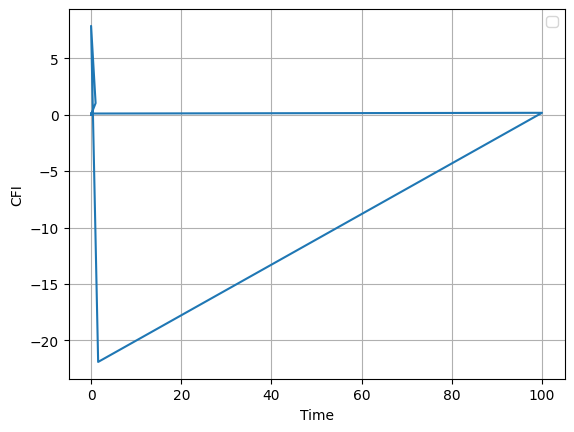

In [31]:
# == Temporary Plot for gamma_ps = 0.8
plt.plot(Optimized_Result[:][0], Optimized_Result[:][1])
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid() 

In [32]:
array = np_.arange(0, 3, 1).reshape(3,1)
b = np_.array([[1,2], [3,4], [5,6]])

res = np_.hstack((array, b))

res

len(array)

3

In [33]:
array = np_.arange(1,10,1)

tuple(array)

(1, 2, 3, 4, 5, 6, 7, 8, 9)

In [34]:
test = 1,2,3,4

type(test)

tuple

In [35]:
dd = np.arange(0, np.pi*3, 0.1)

len(dd)

95